<a href="https://colab.research.google.com/github/daviddkovacs/Global-EVT-maps/blob/main/Batch_export_EVT_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First steps

Welcome! This Python code will create the Global EVT maps and retrieve them in batches to your Google Earth Engine Assets.

Please create an account on Google Earth Engine: https://earthengine.google.com/

The next cell will connect this Python code to your Earth Engine account. 

1.   Run the cell and click the URL
2. Click "Generate token"

3.   Log in to your Google account that you use for Google Earth Engine
4.   Tick both "View and manage GEE data" and "Manage your data in Cloud storage" and click continue
5. Copy the Authorisation code
6. Return to Colab and insert the verification code that you copied

In [ ]:
import ee
ee.Authenticate()
ee.Initialize()

# Defining properties of EVT maps

First, you need to select which variable to export: 


*   FAPAR (Fraction of Absorbed Photosynthetically Active Radiation)
*   LAI (Leaf Area Index)
*   FVC (Fractional Vegetation Cover)
*   LCC (Leaf Chlorophyll Content)

You need to uncomment the variables: "fileName" and "variables_GREEN" for the given variable and run the cell


In [ ]:
# fileName='FAPAR_'
# variables_GREEN = {'FAPAR':['FAPAR', 1, 0.0001]}

# fileName='LAI_'
# variables_GREEN = {'LAI':['LAI', 10, 0.0057]}

# fileName='FVC_'
# variables_GREEN = {'FVC':['FVC', 1, 0.0001]}

# fileName='LCC_'
# variables_GREEN = {'LCC':['LCC', 100, 1.0547]}


Now, you need to create a destination for EVT maps in your GEE directory.

1. Create an empty ImageCollection in your GEE assets where the Python script code can output the maps.

2. Copy the ImageCollection ID as per indicated in GEE and insert it as the assetpath variable

3. Insert this directory as the assetpath variable in the next cell


e.g.: assetpath = "projects/ee-your_username/assets/name_of_your_new_imagecollection"

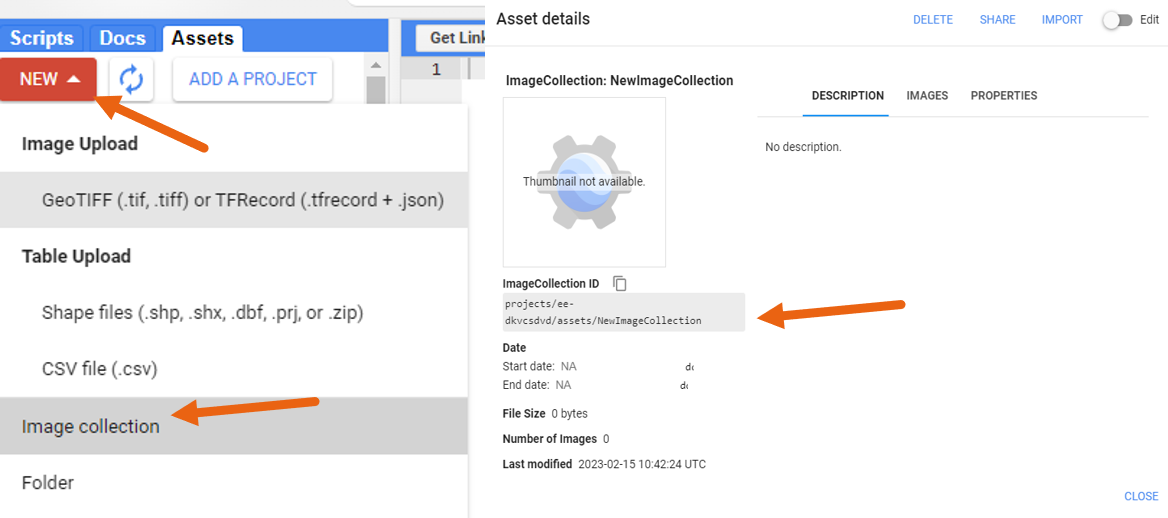

In [ ]:
assetPath= ''+"/" # Copy the ImageCollection ID from your empty asset in GEE here

Now we define:
3. Area of exportation
4. Start and End date for exportation
5. Temporal and spatial resolution

In [ ]:
#Now we define the region for retrieval which is a shapefile. You can upload your own shapefiles and retrieve data in that area too!
fc = ee.FeatureCollection("projects/ee-dkvcsdvd/assets/Output/World_shapefile")

# Select the starting and ending date for retrieval
startDateStr = '2018-07-01'  
endDateStr = '2020-06-01'  

# Define the temporal resolution of retrieval (in days)
timeWindows = 10

# Define the spatial resolution of retrieval (in meters)
pixelsize = 5000

# Installing necessary packages

In [ ]:
pip install geojson

In [ ]:
pip install geopandas

In [ ]:
pip install rasterio

In [ ]:
pip install config

In [ ]:
pip install config_variables

In [ ]:
import sys
sys.path.append('../../')
import config

In [ ]:
!git clone https://github.com/daviddkovacs/Global-EVT-maps.git

In [ ]:
import json
from google.colab import files
import csv
import datetime
import json
import geojson
import pandas as pd
import geopandas as gpd
import rasterio
#import gdal
import importlib
import sys
import numpy as np
import os
from subprocess import getoutput
#import config_variables as config

getoutput("git clone -l -s https://github.com/daviddkovacs/Global-EVT-maps.git cloned-repo")
os.chdir('cloned-repo')


import model_LAI
import model_LCC
import model_FVC
import model_FAPAR
import sys
import requests
import zipfile

import os
from os import listdir
from os.path import isfile,join

from PIL import Image 
import netCDF4
from netCDF4 import Dataset

# Algorithm to retrieve the maps

In [ ]:
S3Olci = ee.ImageCollection("COPERNICUS/S3/OLCI")
startDateGEE = ee.Date(startDateStr)
endDate = datetime.datetime.strptime(endDateStr, '%Y-%m-%d').date()
bands = ['GREEN', 'UNCERTAINTY_GREEN', 'QUALITY_FLAG']
#Ancilliary functions

#Calculate the sample size of the model, used to retrieve K_star


def sequence_GREEN(variable):
	sequence_GREEN = []
	model = globals()['model_' + variable]
	for i in range(0, model.XTrain_dim_GREEN):
		sequence_GREEN.append(str(i))
	return sequence_GREEN

def getInputDates(i):
  fecha_inicio = startDateGEE.advance(ee.Number(i).multiply(timeWindows),'day')
  fecha_fin = fecha_inicio.advance(timeWindows, 'day')
  #fecha_fin = endDateGEE()
  fecha_str = datetime.datetime.utcfromtimestamp(fecha_inicio.getInfo()['value']/1000.0).strftime('%Y%m%d')
  return {'fecha_inicio':fecha_inicio, 'fecha_fin':fecha_fin, 'fecha_str':fecha_str}
  
def maskS3badPixels(image):
  
  qa = ee.Image(image.select('quality_flags'));
  coastLine = 1 << 30;
  inLandWater = 1 << 29;
  bright = 1 << 27;
  invalid = 1 << 25;
  Oa12Sat = 1 << 9;
  mask = qa.bitwiseAnd(coastLine).eq(0).And(qa.bitwiseAnd(inLandWater).eq(0)).And(qa.bitwiseAnd(bright).eq(0))
  
  return image.updateMask(mask);

def addVariables(image):

  date = ee.Date(image.get("system:time_start"));
  years = date.difference(ee.Date('1970-01-01'),'days');
  return image.addBands(ee.Image(years).rename('t').float());

In [ ]:
#GPR Estimations and Uncertainties functions

def calculate_GREEN(fecha_inicio, fecha_fin, variable, limitUp, limitDown): 
  
  model = globals()['model_' + variable]
  image = ee.Image(S3Olci
  .filterDate(fecha_inicio, fecha_fin)
  .filterBounds(fc)
  .map(maskS3badPixels)
  .select(model.bands)
  .max()
  .clipToCollection(fc));
  #.clip(fc));

  
  

  im_norm_ell2D_hypell = image.subtract(model.mx_GREEN).divide(model.sx_GREEN).multiply(model.hyp_ell_GREEN).toArray().toArray(1); 
  im_norm_ell2D = image.subtract(model.mx_GREEN).divide(model.sx_GREEN).toArray().toArray(1); 
  PtTPt  = im_norm_ell2D_hypell.matrixTranspose().matrixMultiply(im_norm_ell2D).arrayProject([0]).multiply(-0.5); #OK

  PtTDX  = ee.Image(model.X_train_GREEN).matrixMultiply(im_norm_ell2D_hypell).arrayProject([0]).arrayFlatten([sequence_GREEN(variable)]);
  arg1   = PtTPt.exp().multiply(model.hyp_sig0_GREEN);
  k_star = PtTDX.subtract(model.XDX_pre_calc_GREEN.multiply(0.5)).exp().toArray();
  mean_pred = k_star.arrayDotProduct(model.alpha_coefficients_GREEN.toArray()).multiply(arg1);
  mean_pred = mean_pred.toArray(1).arrayProject([0]).arrayFlatten([[variable + '_GREEN']]);
  mean_pred = mean_pred.add(model.mean_model_GREEN);#.updateMask(mean_pred.gt(0));
  filterDown = mean_pred.gt(limitDown)
 
  filterUp = mean_pred.lt(limitUp)
  
  mean_pred = mean_pred.multiply(filterDown)
  quality_flags = (filterDown.multiply(filterUp)).Not().toArray().arrayFlatten([[variable + '_QUALITY_FLAG']])

  k_star_uncert = PtTDX.subtract(model.XDX_pre_calc_GREEN.multiply(0.5)).exp().multiply(arg1).toArray();
  Vvector = ee.Image(model.LMatrixInverse).matrixMultiply(k_star_uncert.toArray(0).toArray(1)).arrayProject([0])
  Variance = ee.Image(model.hyp_sig_GREEN).toArray().subtract(Vvector.arrayDotProduct(Vvector)).abs().sqrt()
  Variance = Variance.toArray(1).arrayProject([0]).arrayFlatten([[variable + '_UNCERTAINTY_GREEN']])

  
  image= image.addBands(mean_pred);
  image = image.addBands(Variance);
  image = image.addBands(quality_flags);

  return image.select(variable + '_GREEN', variable + '_UNCERTAINTY_GREEN', variable + '_QUALITY_FLAG');

In [ ]:
#Iterations:

def maploop():
    
		startDate = datetime.datetime.strptime(startDateStr, "%Y-%m-%d").date()
		#endDate = datetime.datetime.strptime(endDate, "%Y-%m-%d").date()
		#endDate = datetime.datetime.strptime(endDate, "%Y-%m-%d").date()
		daysIterations = abs((startDate - endDate)//timeWindows).days

		  

		for i in range(0,daysIterations):
			print(getInputDates(i)['fecha_str'])
			imageHolder = ee.Image().set('system:time_start', startDateGEE.advance(ee.Number(i).multiply(timeWindows),'days').millis());

			for variable_GREEN in variables_GREEN:
				params = variables_GREEN[variable_GREEN]
				variable = params[0]
				limitUp = params[1]
				limitDown = params[2]
				imagen = calculate_GREEN(getInputDates(i)['fecha_inicio'], getInputDates(i)['fecha_fin'], variable, limitUp, limitDown)#.multiply(10000).toInt32()
				imageHolder = imageHolder.addBands(imagen)

				#image_export = imageHolder.select('LAI_GREEN', 'LAI_UNCERTAINTY_GREEN', 'LAI_QUALITY_FLAG', 'LCC_GREEN', 'LCC_UNCERTAINTY_GREEN', 'LCC_QUALITY_FLAG',
				#'FAPAR_GREEN', 'FAPAR_UNCERTAINTY_GREEN', 'FAPAR_QUALITY_FLAG', 'FVC_GREEN', 'FVC_UNCERTAINTY_GREEN', 'FVC_QUALITY_FLAG')

				image_export = imageHolder.select('LCC_GREEN', 'LCC_UNCERTAINTY_GREEN', 'LCC_QUALITY_FLAG')

				exportar = ee.batch.Export.image.toAsset(
				assetId= assetPath  + getInputDates(i)['fecha_str'] + variable_GREEN + fileName,
				image=image_export,
				#image=imagen,
				maxPixels=3263189952,
				
				#maxPixels=4731453308 ,
				description=  getInputDates(i)['fecha_str'] + variable_GREEN + fileName,
				#fileFormat='GeoTiff',
				scale=pixelsize,
				region=fc.geometry()#.bounds().getInfo()['coordinates']
				)
				exportar.start()
				exportar.status()

Run the next cell to call the function to start exporting the maps. You can check the status of the exportation in your GEE Task Manager: https://code.earthengine.google.com/tasks

In [ ]:
maploop()